## Artwork Genre Classification

- import libraries

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import *
from tqdm import tqdm, tqdm_notebook

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)

2023-04-08 11:33:49.560498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


- data preprocessing

In [2]:
print(os.listdir("images_genre"))

['Early_Renaissance', 'Expressionism', '.DS_Store', 'Northern_Renaissance', 'Proto_Renaissance', 'Pop_Art', 'High_Renaissance', 'Neoplasticism', 'Mannerism', 'Symbolism', 'Realism', 'Primitivism', 'Romanticism', 'Surrealism', 'Cubism', 'Impressionism', 'Byzantine Art', 'Suprematism', 'Baroque', 'Post_Impressionism', 'Abstract_Expressionism']


In [3]:
genre = pd.read_csv('genre.csv')

In [4]:
# Sort artists by number of paintings
genre = genre.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with genre having more than 150 paintings
genre_top = genre[genre['paintings'] >= 150].reset_index()
genre_top = genre_top[['genre', 'paintings']]
#genre_top['class_weight'] = max(genre_top.paintings)/artists_top.paintings
genre_top['class_weight'] = genre_top.paintings.sum() / (genre_top.shape[0] * genre_top.paintings)
genre_top

,genre,paintings,class_weight
0,Impressionism,1370,0.340876
1,Post_Impressionism,1048,0.445611
2,Northern_Renaissance,680,0.686765
3,Baroque,586,0.796928
4,Cubism,439,1.063781
5,Romanticism,388,1.203608
6,Primitivism,309,1.511327
7,High_Renaissance,301,1.551495
8,Surrealism,241,1.937759
9,Expressionism,193,2.419689


In [5]:
sum(genre_top['paintings'])

6071

In [6]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = genre_top['class_weight'].to_dict()
class_weights

{0: 0.34087591240875914,
 1: 0.44561068702290074,
 2: 0.6867647058823529,
 3: 0.7969283276450512,
 4: 1.0637813211845102,
 5: 1.2036082474226804,
 6: 1.5113268608414239,
 7: 1.5514950166112957,
 8: 1.937759336099585,
 9: 2.4196891191709846,
 10: 2.5801104972375692,
 11: 2.7309941520467835,
 12: 2.847560975609756}

In [7]:
# Explore images of top genre
images_dir = 'images_genre'
genre_dirs = os.listdir(images_dir)
top_genre = genre_top['genre']

# See if all directories exist
for name in top_genre:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> images_genre/Impressionism
Found --> images_genre/Post_Impressionism
Found --> images_genre/Northern_Renaissance
Found --> images_genre/Baroque
Found --> images_genre/Cubism
Found --> images_genre/Romanticism
Found --> images_genre/Primitivism
Found --> images_genre/High_Renaissance
Found --> images_genre/Surrealism
Found --> images_genre/Expressionism
Found --> images_genre/Pop_Art
Found --> images_genre/Symbolism
Found --> images_genre/Early_Renaissance


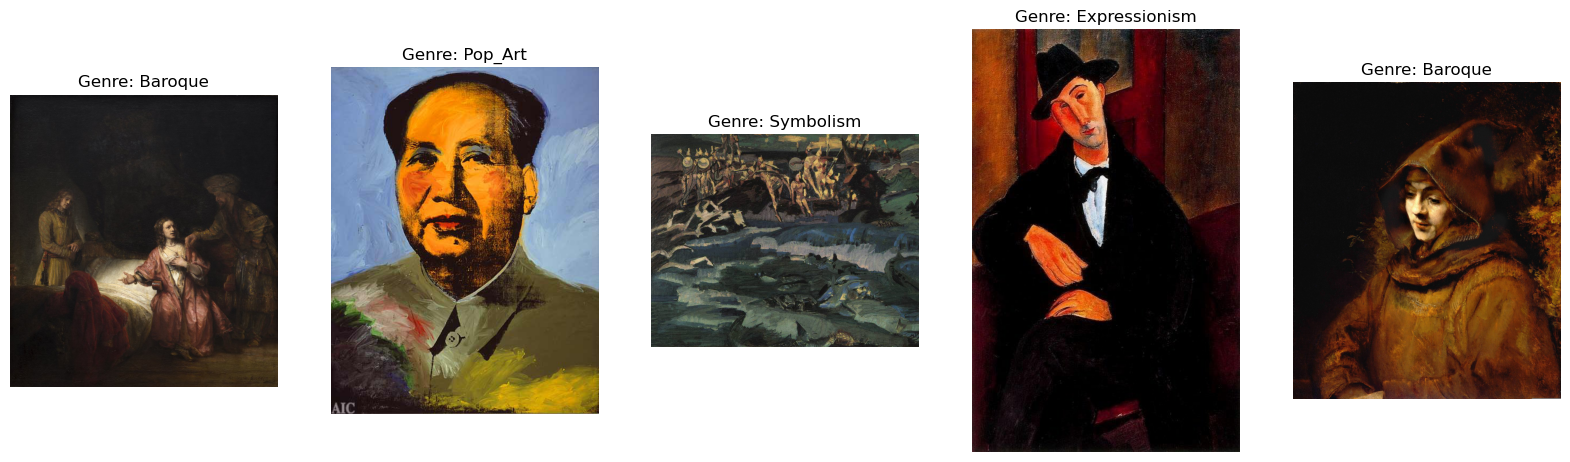

In [8]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_genre = random.choice(top_genre)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_genre)))
    random_image_file = os.path.join(images_dir, random_genre, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Genre: " + random_genre)
    axes[i].axis('off')

plt.show()

- split train and test data

In [9]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = genre_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=top_genre.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=top_genre.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 4862 images belonging to 13 classes.
Found 1209 images belonging to 13 classes.
Total number of batches = 303 and 75


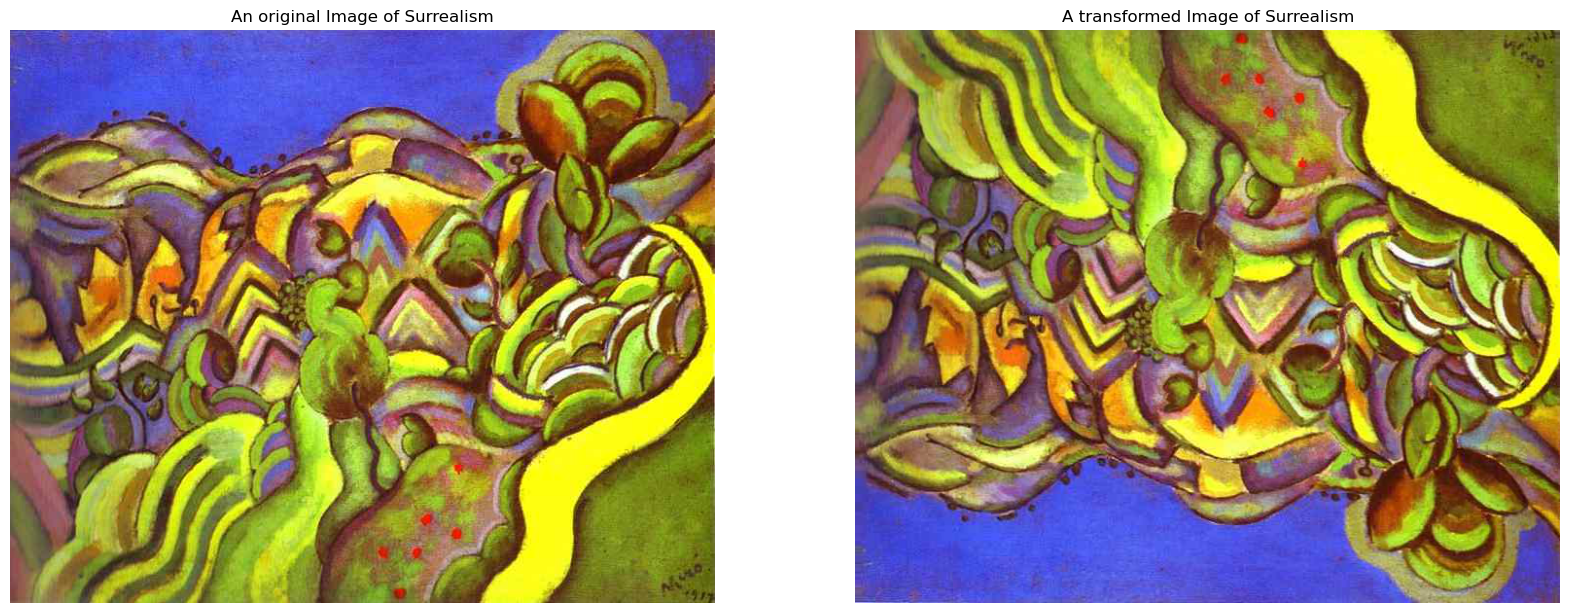

In [10]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_genre = random.choice(top_genre)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_genre)))
random_image_file = os.path.join(images_dir, random_genre, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_genre)
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_genre)
axes[1].axis('off')

plt.show()

- build model

In [11]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

2023-04-08 11:33:53.999784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [13]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

/Users/lingtianhan/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
n_epoch = 20

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

- test model: first tempt

In [15]:
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              #use_multiprocessing=True,
                              #workers=16,
                              class_weight=class_weights
                             )

/var/folders/tc/hjg8dsq54vzfrk5v6v96k32r0000gn/T/ipykernel_73167/2479344110.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/20
303/303 [==============================] - 944s 3s/step - loss: 1.9455 - accuracy: 0.2602 - val_loss: 3.5424 - val_accuracy: 0.0300 - lr: 1.0000e-04
Epoch 2/20
303/303 [==============================] - 943s 3s/step - loss: 1.4566 - accuracy: 0.4818 - val_loss: 3.3427 - val_accuracy: 0.0458 - lr: 1.0000e-04
Epoch 3/20
303/303 [==============================] - 925s 3s/step - loss: 1.2680 - accuracy: 0.5683 - val_loss: 2.7945 - val_accuracy: 0.2025 - lr: 1.0000e-04
Epoch 4/20
303/303 [==============================] - 922s 3s/step - loss: 1.1397 - accuracy: 0.6488 - val_loss: 2.1176 - val_accuracy: 0.3958 - lr: 1.0000e-04
Epoch 5/20
303/303 [==============================] - 936s 3s/step - loss: 0.9821 - accuracy: 0.7119 - val_loss: 1.8391 - val_accuracy: 0.4842 - lr: 1.0000e-04
Epoch 6/20
303/303 [==============================] - 934s 3s/step - loss: 0.8490 - accuracy: 0.7846 - val_loss: 1.7546 - val_accuracy: 0.4958 - lr: 1.0000e-04
Epoch 7/20
303/303 [====================

- plot loss and accuracy

In [16]:
history = {}
history['loss'] = history1.history['loss']
history['acc'] = history1.history['accuracy']
history['val_loss'] = history1.history['val_loss']
history['val_acc'] = history1.history['val_accuracy']
history['lr'] = history1.history['lr']

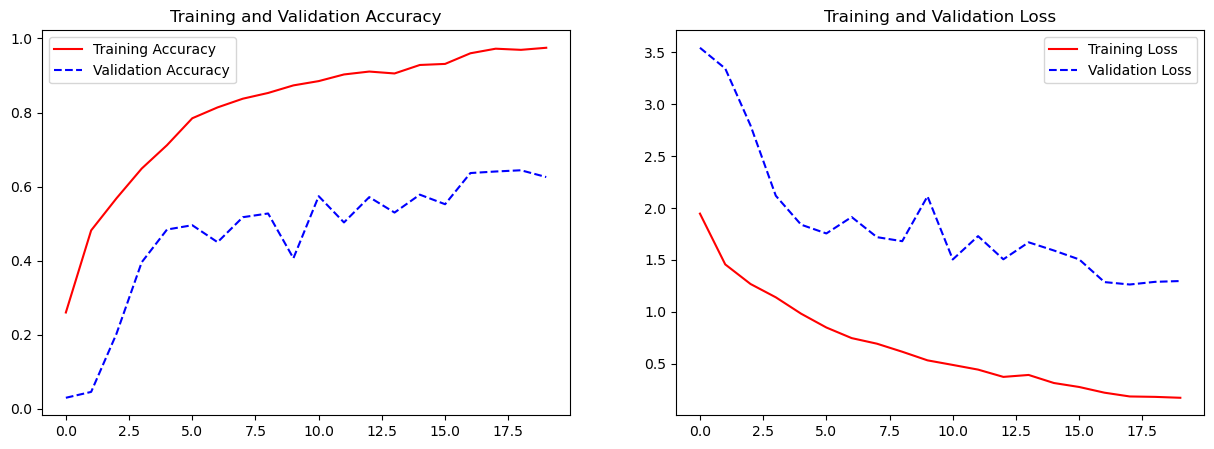

In [17]:
# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

- plot cofusion matrix

In [18]:
def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=top_genre.tolist()))

1/1 [==============================] - 1s 744ms/step


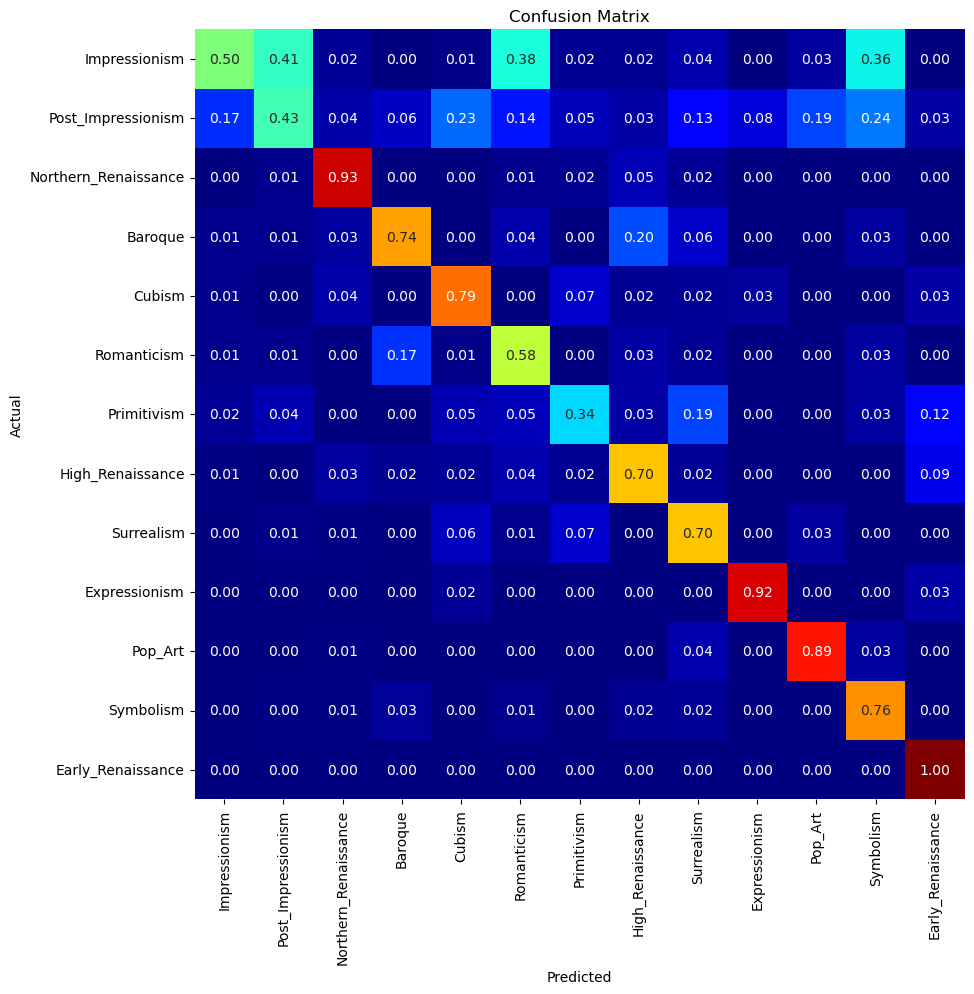

Classification Report:
                      precision    recall  f1-score   support

       Impressionism       0.67      0.50      0.57       272
  Post_Impressionism       0.45      0.43      0.44       209
Northern_Renaissance       0.84      0.93      0.88       135
             Baroque       0.73      0.74      0.74       116
              Cubism       0.66      0.79      0.72        87
         Romanticism       0.45      0.58      0.51        76
         Primitivism       0.59      0.34      0.43        59
    High_Renaissance       0.64      0.70      0.67        60
          Surrealism       0.55      0.70      0.62        47
       Expressionism       0.90      0.92      0.91        38
             Pop_Art       0.78      0.89      0.83        36
           Symbolism       0.51      0.76      0.61        33
   Early_Renaissance       0.76      1.00      0.86        32

            accuracy                           0.64      1200
           macro avg       0.66      0.71    

In [19]:
# Classification report and confusion matrix
tick_labels = top_genre.tolist()

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

- test model: second tempt

In [20]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:20]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 30
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              #use_multiprocessing=True,
                              #workers=16,
                              class_weight=class_weights
                             )

/Users/lingtianhan/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/tc/hjg8dsq54vzfrk5v6v96k32r0000gn/T/ipykernel_73167/2127363697.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/50
303/303 [==============================] - 823s 3s/step - loss: 0.0798 - accuracy: 0.9934 - val_loss: 1.3847 - val_accuracy: 0.6233 - lr: 1.0000e-04
Epoch 2/50
303/303 [==============================] - 839s 3s/step - loss: 0.0725 - accuracy: 0.9961 - val_loss: 1.4287 - val_accuracy: 0.6033 - lr: 1.0000e-04
Epoch 3/50
303/303 [==============================] - 828s 3s/step - loss: 0.0674 - accuracy: 0.9944 - val_loss: 1.3887 - val_accuracy: 0.6133 - lr: 1.0000e-04
Epoch 4/50
303/303 [==============================] - 829s 3s/step - loss: 0.0691 - accuracy: 0.9934 - val_loss: 1.2955 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 5/50
303/303 [==============================] - 820s 3s/step - loss: 0.0577 - accuracy: 0.9959 - val_loss: 1.3218 - val_accuracy: 0.6350 - lr: 1.0000e-04
Epoch 6/50
303/303 [==============================] - 798s 3s/step - loss: 0.0573 - accuracy: 0.9961 - val_loss: 1.4470 - val_accuracy: 0.6150 - lr: 1.0000e-04
Epoch 7/50
303/303 [====================

- plot loss and accuracy

In [21]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

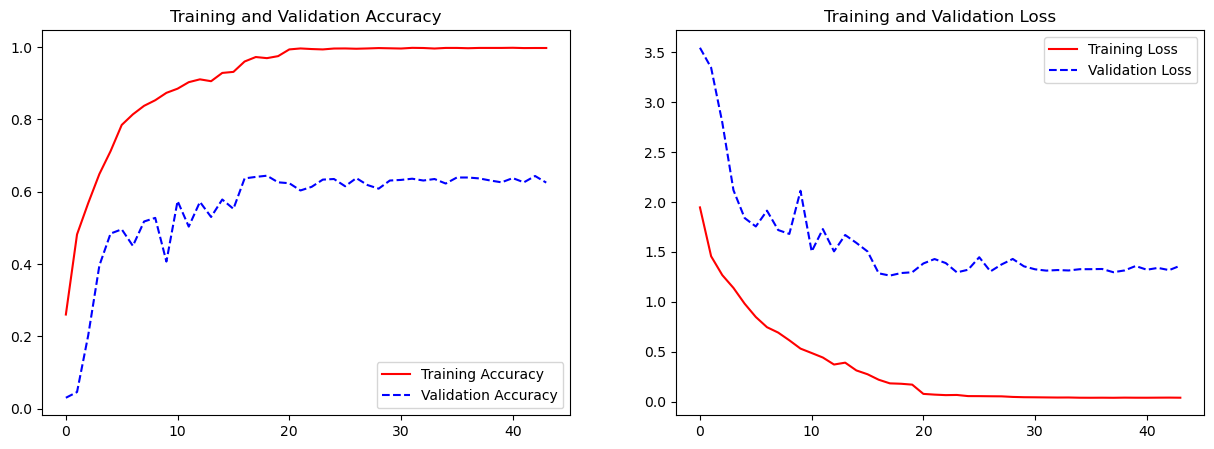

In [22]:
# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

1/1 [==============================] - 1s 728ms/step


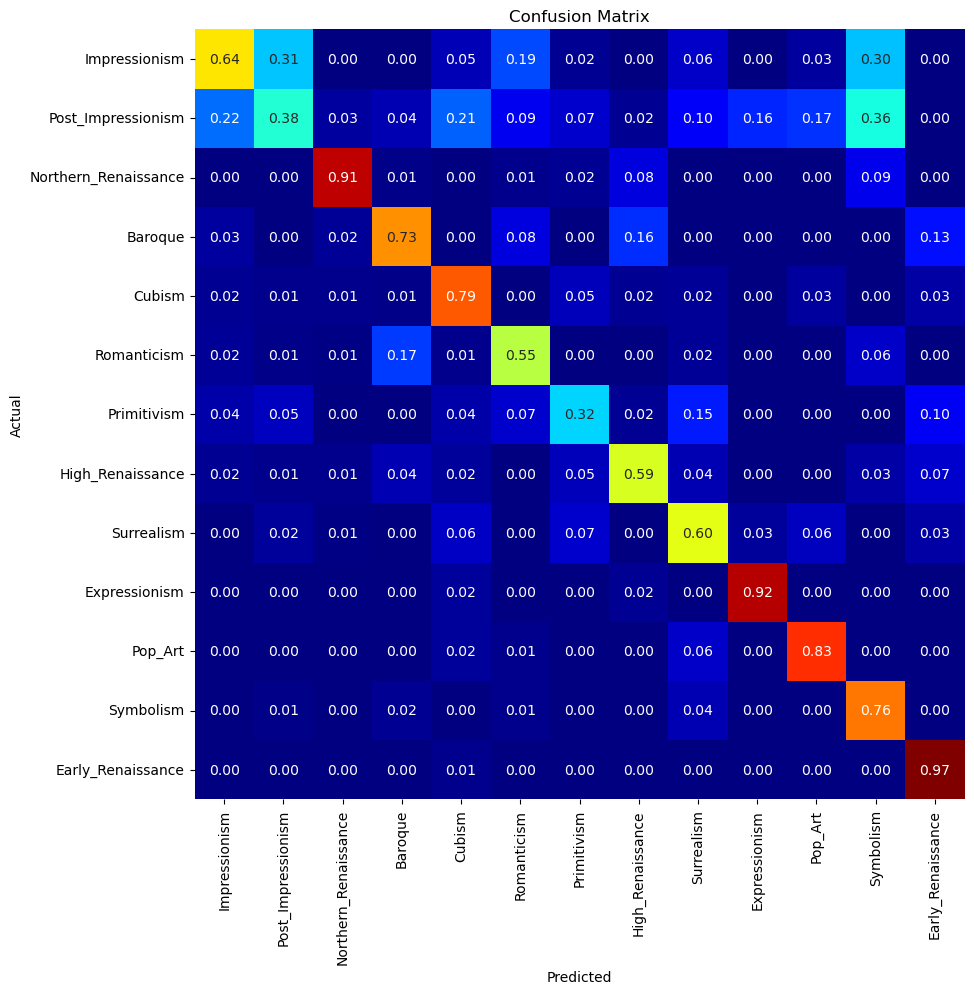

Classification Report:
                      precision    recall  f1-score   support

       Impressionism       0.64      0.64      0.64       272
  Post_Impressionism       0.47      0.38      0.42       208
Northern_Renaissance       0.90      0.91      0.91       134
             Baroque       0.71      0.73      0.72       115
              Cubism       0.64      0.79      0.71        85
         Romanticism       0.54      0.55      0.55        74
         Primitivism       0.54      0.32      0.40        59
    High_Renaissance       0.65      0.59      0.62        61
          Surrealism       0.55      0.60      0.57        48
       Expressionism       0.83      0.92      0.88        38
             Pop_Art       0.75      0.83      0.79        36
           Symbolism       0.47      0.76      0.58        33
   Early_Renaissance       0.72      0.97      0.83        30

            accuracy                           0.65      1193
           macro avg       0.65      0.69    

In [23]:
# Classification report and confusion matrix
showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)